<a href="https://colab.research.google.com/github/subai-ro/usl.projects/blob/main/Network%20Intrusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploration of Network Intrusion Detection

Mikita Silivestrau

01.02.2025

Dataset information
https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection/data

Short summary: The dataset to be audited was provided which consists of a wide variety of intrusions simulated in a military network environment. It created an environment to acquire raw TCP/IP dump data for a network by simulating a typical US Air Force LAN. 41 quantitative and qualitative features are obtained from normal and attack data (3 qualitative and 38 quantitative features).

The class variable has two categories:

• Normal

• Anomalous


Introduction

The goal of this paper is to explore the train dataset performing dimension reduction, applying several clustering technics and conducting association rules mining. We will provide the results of each task, interpret the result and see whether it was possible to obtain meaningful information from our analysis.

Let's start with loadings pf packages and data and initial inspection

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from collections import Counter

# HDBSCAN
!pip install hdbscan
import hdbscan

###############################################################################
# 1. DATA LOADING AND INITIAL INSPECTION
###############################################################################
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv("/content/gdrive/My Drive/Train_data_Intrusion1.csv", sep=';')

print("First 5 rows:")
print(df.head(), "\n")

print("Columns:")
print(df.columns, "\n")

print("Dataset info:")
print(df.info(), "\n")

print("Class value counts:")
print(df['class'].value_counts(), "\n")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
First 5 rows:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0             

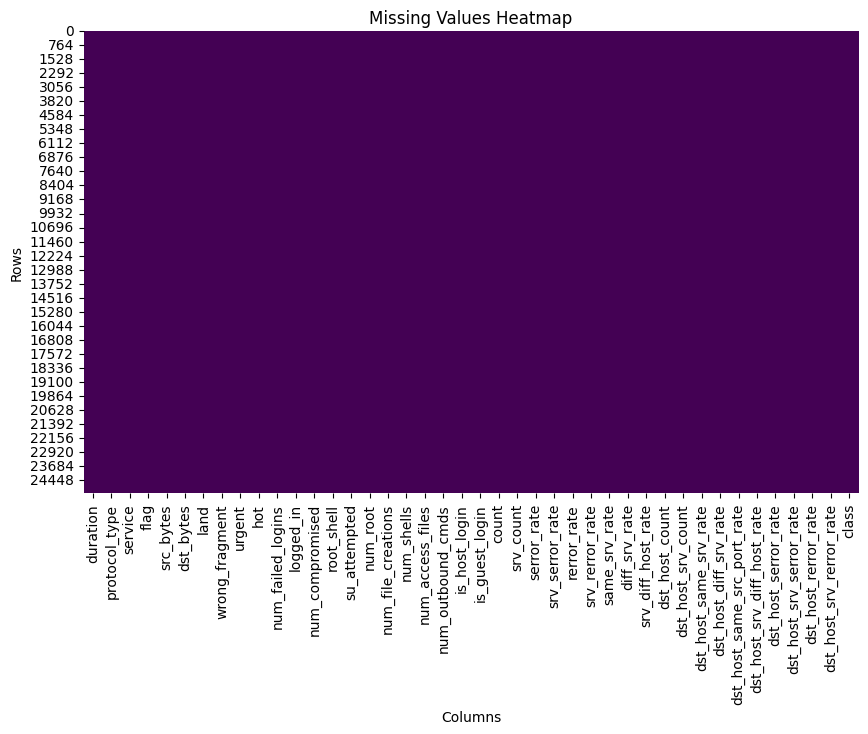

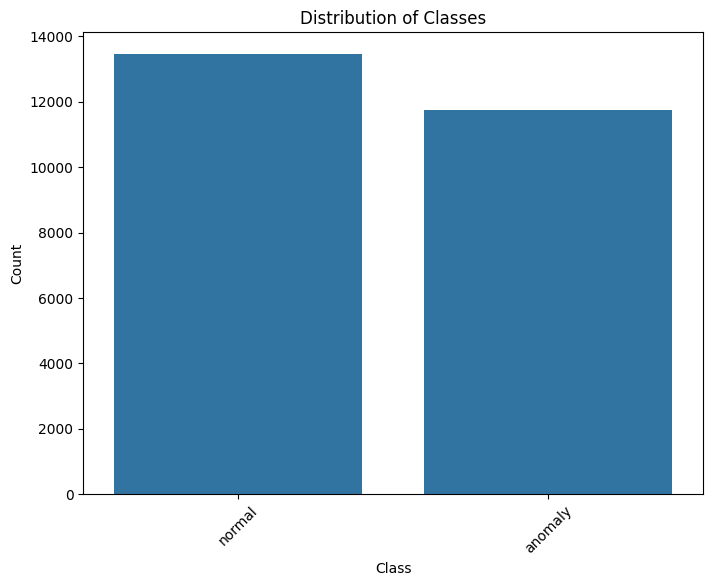

In [13]:
###############################################################################
# VISUALIZATIONS FOR INITIAL INSPECTION
###############################################################################

# 1. Missing Values Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# 2. Count Plot of the 'class' Column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


The heatmap visually represents the presence of missing values in the dataset.
The dark purple color indicates that there are no missing values in any of the columns. Since the entire heatmap is a solid dark color, it suggests that your dataset is complete, meaning there are no missing values across all rows and columns.

This Distribution of Classes bar chart shows the distribution of two classes: normal and anomaly.
The class normal has a slightly higher count than anomaly, indicating that the dataset is somewhat balanced but has slightly more normal observations.
Since the two categories have a relatively similar number of samples, the model may not be heavily biased toward one class, reducing the need for additional balancing techniques.

In [14]:
# Calculate the correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)


Correlation Matrix:
                             duration  src_bytes  dst_bytes      land  \
duration                     1.000000   0.084864   0.013258 -0.001012   
src_bytes                    0.084864   1.000000   0.003611 -0.000090   
dst_bytes                    0.013258   0.003611   1.000000 -0.000350   
land                        -0.001012  -0.000090  -0.000350  1.000000   
wrong_fragment              -0.010358  -0.000916  -0.003586 -0.000813   
urgent                      -0.000486  -0.000062   0.000345 -0.000056   
hot                          0.004202   0.000995   0.002539 -0.000819   
num_failed_logins            0.011108  -0.000260   0.005197 -0.000234   
logged_in                   -0.063703  -0.002040   0.012704 -0.007196   
num_compromised              0.095215  -0.000196   0.035852 -0.000195   
root_shell                   0.050547  -0.000383   0.020214 -0.000351   
su_attempted                 0.094243  -0.000267   0.035041 -0.000247   
num_root                     0.

Removing near-constant / zero-variance columns

There are columns that have almost the same value for most rows (zero or near‐zero variance). Such columns rarely help in clustering or association rules.

In [15]:
from sklearn.feature_selection import VarianceThreshold

# 2) Remove near-zero variance columns
# -----------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
vt = VarianceThreshold(threshold=0.01)  # Adjust the threshold as needed
vt.fit(df[numeric_cols])

low_variance_cols = [col for col, var in zip(numeric_cols, vt.variances_) if var < 0.01]
if low_variance_cols:
    print(f"Near-zero variance columns dropped: {low_variance_cols}")
    df.drop(columns=low_variance_cols, inplace=True)

# Re-compute numeric_cols after dropping columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

Near-zero variance columns dropped: ['land', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']


Let's separate and drop the class label (to mimic unsupervised learning). We will use it later for validation of results.

In [18]:
# 2.1 Separate the 'class' labels
true_labels = df['class'].copy()

# 2.2 Drop 'class' from features
df.drop('class', axis=1, inplace=True)


Now we encode and scale the values for preprocessing.

In [19]:
# 2.3 Encode categorical columns if they exist
categorical_cols = ['protocol_type', 'service', 'flag']  # Modify if needed
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# 2.4 Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

print("Shape of scaled data:", X_scaled.shape)


Shape of scaled data: (25192, 31)


Since we still have high number of dimension (31), it will be beneficial to apply dimension reduction. We are going to compute explained variancies for principal componentent number roughly equal to half of total number of dimensions.

In [23]:
# Set number of components for initial variance check
n_components_check = 15
pca_check = PCA(n_components=n_components_check, random_state=42)
pca_check.fit(X_scaled)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_check.explained_variance_ratio_)

# Print explained variance details
print(f"\nPCA -> Computed for {n_components_check} components.")
print("Explained variance (each component):", pca_check.explained_variance_ratio_)
print("Cumulative explained variance:", cumulative_variance)


PCA -> Computed for 15 components.
Explained variance (each component): [0.24872699 0.1671402  0.06821395 0.06552319 0.05497027 0.05170879
 0.03675177 0.03533186 0.0332394  0.03221558 0.03121899 0.02992816
 0.02510589 0.02255095 0.01980664]
Cumulative explained variance: [0.24872699 0.41586719 0.48408114 0.54960433 0.6045746  0.65628339
 0.69303516 0.72836702 0.76160643 0.79382201 0.825041   0.85496916
 0.88007505 0.902626   0.92243264]


We are going to proceed with 10 principal components since they explain pretty sufficient number of variance (0.69303516) and increasing their number further is not really beneficial since the increase in explained variance drops.


In [24]:
n_components_final = 7
pca = PCA(n_components=n_components_final, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Print final PCA details
print(f"\nPCA -> Reduced to {n_components_final} components.")
print("Final explained variance (each component):", pca.explained_variance_ratio_)
print("Final cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))
print("Shape of X_pca:", X_pca.shape, "\n")


PCA -> Reduced to 7 components.
Final explained variance (each component): [0.24872699 0.1671402  0.06821395 0.06552319 0.05497027 0.05170879
 0.03675177]
Final cumulative explained variance: [0.24872699 0.41586719 0.48408114 0.54960433 0.6045746  0.65628339
 0.69303516]
Shape of X_pca: (25192, 7) 



Now we are going to calculate Hopkins statistics to check for clusterability of scaled and PCA-reduced data.

In [30]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(X, n_samples=100):
    """
    Computes the Hopkins statistic for a dataset X.

    Parameters:
      - X: numpy array of shape (n_samples, n_features)
      - n_samples: number of samples to use for the computation (default=100)

    Returns:
      - hopkins_value: A value between 0 and 1.
         Values close to 1 indicate high cluster tendency,
         around 0.5 suggest randomness (no natural clusters).
    """
    X = np.array(X)
    n = X.shape[0]

    # If n_samples is larger than the dataset, use the size of the dataset.
    if n_samples > n:
        n_samples = n

    # Randomly select n_samples points from X
    random_indices = np.random.choice(range(n), n_samples, replace=False)
    X_sample = X[random_indices]

    # Generate random points within the same bounds as X
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    uniform_random_points = np.random.uniform(mins, maxs, (n_samples, X.shape[1]))

    # Fit NearestNeighbors on the original data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)

    # For each sample point, the first neighbor is itself (distance=0),
    # so we take the second closest.
    distances_sample, _ = nbrs.kneighbors(X_sample)
    distances_random, _ = nbrs.kneighbors(uniform_random_points)

    # Sum the distances:
    # - u: distances from each sample point to its nearest neighbor (ignoring self)
    # - w: distances from each random point to its nearest neighbor in X
    u = np.sum(distances_sample[:, 1])
    w = np.sum(distances_random[:, 0])

    hopkins_value = w / (w + u)
    return hopkins_value

# Example: Compute Hopkins on both X_scaled and X_pca

# On the scaled data (before PCA)
hopkins_scaled = hopkins_statistic(X_scaled, n_samples=100)
print("Hopkins Statistic on Scaled Data:", hopkins_scaled)

# On the PCA-reduced data (which you'll use for clustering)
hopkins_pca = hopkins_statistic(X_pca, n_samples=100)
print("Hopkins Statistic on PCA Data:", hopkins_pca)


Hopkins Statistic on Scaled Data: 0.9987494969655237
Hopkins Statistic on PCA Data: 0.9987132614876602


Both of them are highly clusterable.


Checking the Elbow and Silhouette scores for K-means


k=2: Inertia=365413.63, Silhouette Score=0.475
k=3: Inertia=240321.37, Silhouette Score=0.580
k=4: Inertia=206207.95, Silhouette Score=0.567
k=5: Inertia=182635.37, Silhouette Score=0.580
k=6: Inertia=149320.19, Silhouette Score=0.625
k=7: Inertia=131241.14, Silhouette Score=0.636
k=8: Inertia=90365.90, Silhouette Score=0.638
k=9: Inertia=80831.22, Silhouette Score=0.634
k=10: Inertia=75453.11, Silhouette Score=0.639


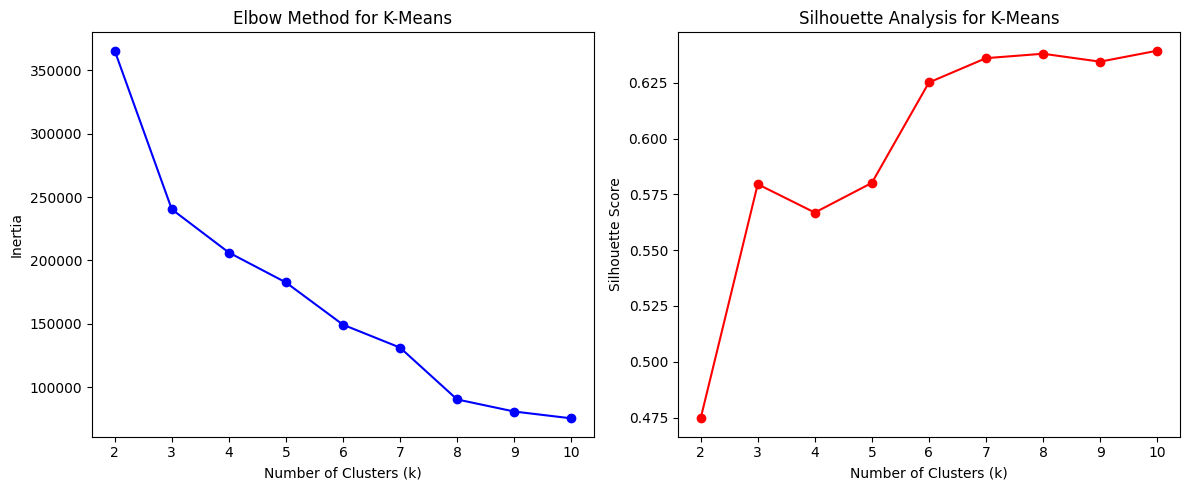

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Suppose you plan to cluster your PCA-reduced data (X_pca)
K_range = range(2, 11)  # Evaluate k from 2 to 10
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    inertias.append(kmeans.inertia_)
    # Silhouette score is only meaningful if there are at least 2 clusters
    score = silhouette_score(X_pca, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={score:.3f}")

# Plot the Elbow (inertia vs k)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')

# Plot Silhouette Score vs k
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-Means')

plt.tight_layout()
plt.show()


Inertia:

Inertia (the within-cluster sum of squares) decreases as you increase the number of clusters.
Notice that the largest drop in inertia occurs in the transition from lower values of k (e.g., k=2 to k=6). After k=7, the decrease is less dramatic, which suggests that the "elbow" of the curve is around 7 clusters.


Silhouette Score:

The silhouette score measures how similar an object is to its own cluster compared to other clusters, with higher values indicating better-defined clusters.
The score increases significantly up to k=7, then it flattens out (k=7: 0.636, k=8: 0.638, k=9: 0.634, k=10: 0.639).
Even though k=10 gives the highest silhouette score (0.639), the improvement beyond k=7 is marginal. This means you’re not gaining much in cluster separation by increasing the number of clusters beyond 7.

Basing on the above, let's choose k=7



Cluster Distribution:
0    11077
1     6953
3     2831
4     1883
2     1355
5      928
6      165
Name: count, dtype: int64
Overall Silhouette Score for k=7: 0.636


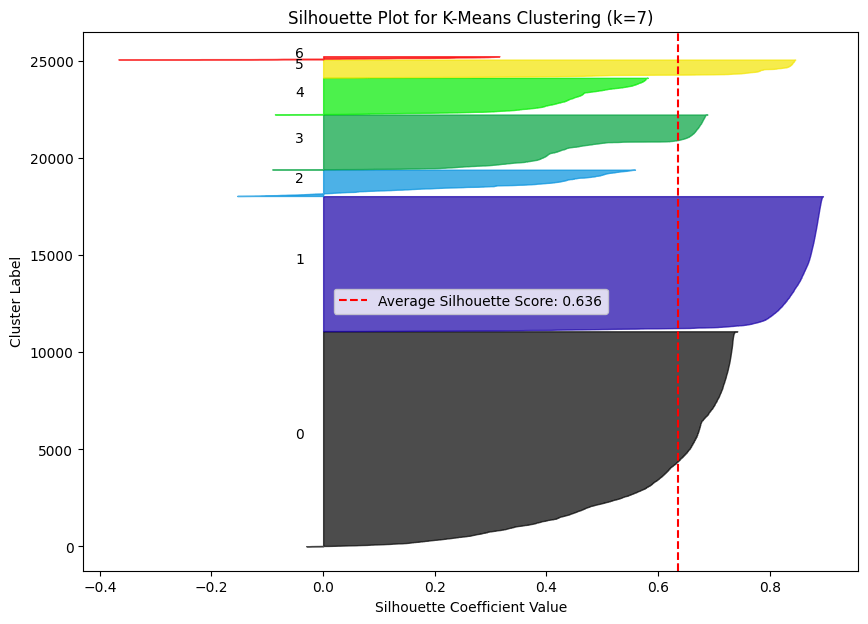

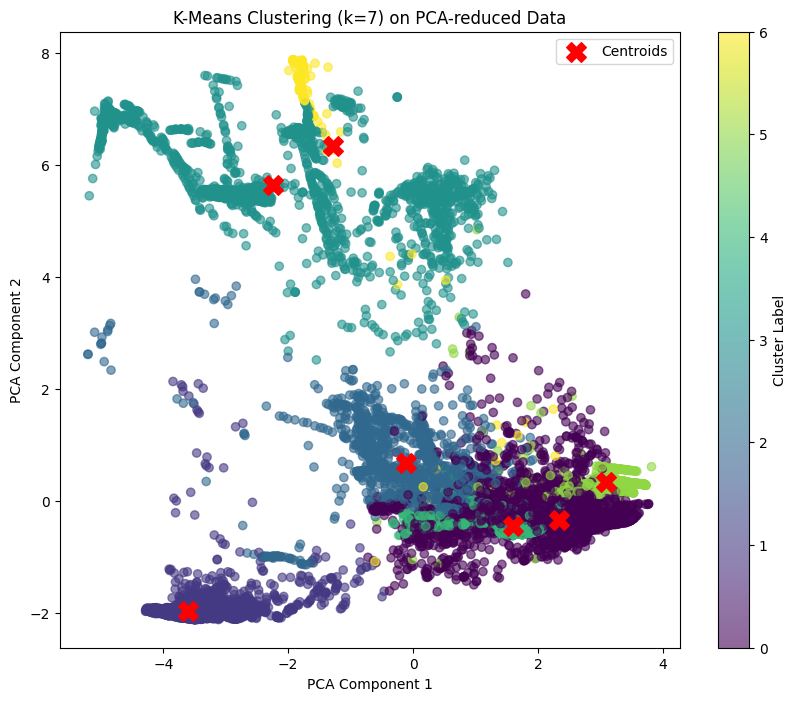

Crosstab of True Labels vs. Cluster Labels:
Cluster Label      0     1    2     3     4    5    6
True Label                                           
anomaly          529  6928  534  2273   495  845  139
normal         10548    25  821   558  1388   83   26
Adjusted Rand Index: 0.477


In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# ------------------------------
# 1. Run K-Means with k = 7
# ------------------------------
k = 7
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)  # Use PCA-reduced data

# Print the distribution of samples across clusters
print("Cluster Distribution:")
print(pd.Series(cluster_labels).value_counts())

# Compute and print the overall silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Overall Silhouette Score for k={k}: {silhouette_avg:.3f}")

# ------------------------------
# 2. Detailed Silhouette Plot
# ------------------------------
sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

plt.figure(figsize=(10, 7))
y_lower = 10  # starting y position for the first cluster plot
for i in range(k):
    # Aggregate silhouette scores for samples in cluster i, then sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers in the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Update y_lower for next plot (with spacing)
    y_lower = y_upper + 10

plt.xlabel("Silhouette Coefficient Value")
plt.ylabel("Cluster Label")
plt.title("Silhouette Plot for K-Means Clustering (k=7)")
plt.axvline(x=silhouette_avg, color="red", linestyle="--",
            label=f"Average Silhouette Score: {silhouette_avg:.3f}")
plt.legend()
plt.show()

# ------------------------------
# 3. Scatter Plot of Clusters
# ------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.6)
# Overlay the cluster centers (in PCA space)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centroids")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering (k=7) on PCA-reduced Data")
plt.colorbar(scatter, label="Cluster Label")
plt.legend()
plt.show()

# ------------------------------
# 4. Crosstab with True Labels
# ------------------------------
# If you have true labels stored in a variable 'true_labels' (as in your earlier code),
# you can generate a crosstab to compare true classes with the clusters.
if 'true_labels' in globals():
    # Ensure that the true_labels array matches the order of the data used for clustering.
    df_crosstab = pd.crosstab(true_labels, cluster_labels,
                              rownames=['True Label'], colnames=['Cluster Label'])
    print("Crosstab of True Labels vs. Cluster Labels:")
    print(df_crosstab)

from sklearn.metrics import adjusted_rand_score

# Assuming cluster_labels are from your K-Means and true_labels are your ground truth
ari = adjusted_rand_score(true_labels, cluster_labels)
print(f"Adjusted Rand Index: {ari:.3f}")



# Cluster Purity (based on Crosstab and Adjusted Rand index):

**High Purity Clusters:**

Cluster 1: Almost entirely anomalies (6,928 vs. 25)

Cluster 5: Largely anomalies (845 vs. 83)

Cluster 6: Mostly anomalies (139 vs. 26)


**Normal-Dominated Clusters:**

Cluster 0: Primarily normal (10,548 vs. 529)

Cluster 4: Also skewed towards normal (1,388 vs. 495)


**Mixed Cluster:**

Cluster 2: Contains a mix but leans towards normal.

Cluster 3: Although it has a significant number of anomalies (2,273), it also has a fair share of normals (558).

**Separation Quality:**

Some clusters clearly separate the anomalies from the normals. For example, cluster 1 is almost exclusively anomalies, which suggests that the K-Means algorithm (with k=7) is able to isolate a set of data points that are very different from the normal behavior.

**Potential for Further Refinement:**

The mixed clusters (like cluster 2) might need further investigation. We might explore whether additional features or a different clustering algorithm could further separate these groups.

The above is also supported by Adjusted Rand Index: 0.477 which shows medium quiality of separation.


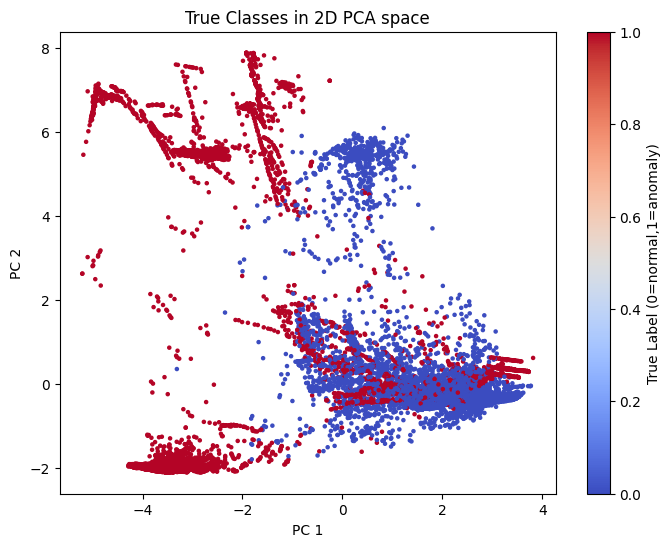

In [34]:
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Color by 'true_labels' (normal=0, anomaly=1)
label_map = {'normal':0, 'anomaly':1}
numeric_labels = true_labels.map(label_map)

plt.figure(figsize=(8,6))
scatter_gt = plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=numeric_labels, cmap="coolwarm", s=5)
plt.colorbar(scatter_gt, label="True Label (0=normal,1=anomaly)")
plt.title("True Classes in 2D PCA space")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()


As per above graphs, the k = 7

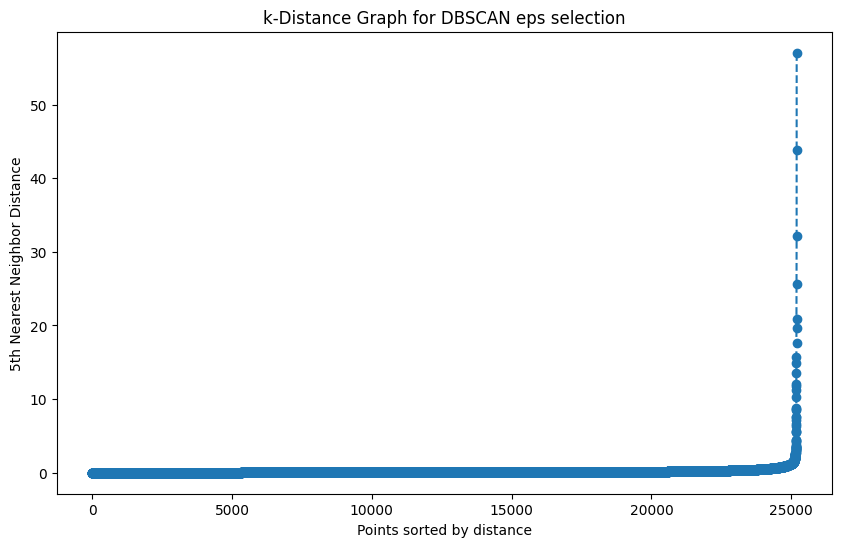

In [37]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Choose min_samples (commonly 5, but it can be tuned)
min_samples = 5

# Fit NearestNeighbors on the PCA data (or X_scaled, depending on your use case)
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# For each point, consider the distance to its kth (min_samples-th) neighbor
kth_distances = np.sort(distances[:, -1])  # last column is the kth neighbor

plt.figure(figsize=(10, 6))
plt.plot(kth_distances, marker='o', linestyle='--')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
plt.title('k-Distance Graph for DBSCAN eps selection')
plt.show()


Based on k-Distance Graph optimal epsilon (eps) for DBSCAN should be chosen at the "elbow" point, where the distance values start increasing rapidly; we could assume values of eps in range [2,3]. Let's proceed with mid value of 2.5



DBSCAN Cluster Distribution (including noise labeled as -1):
 0    25093
 1       54
-1       40
 2        5
Name: count, dtype: int64
Silhouette Score (excluding noise): 0.335
Adjusted Rand Index (excluding noise): 0.001


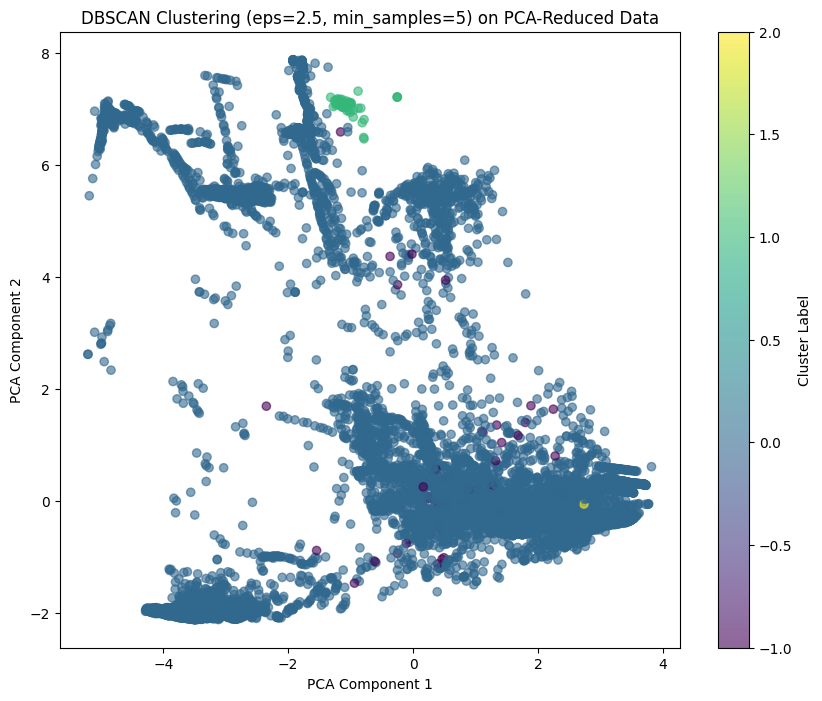

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# ------------------------------
# 1. Run DBSCAN with eps=2.5, min_samples=5
# ------------------------------
dbscan = DBSCAN(eps=2.5, min_samples=5)
labels_db = dbscan.fit_predict(X_pca)

# ------------------------------
# 2. Check Cluster Distribution
# ------------------------------
print("DBSCAN Cluster Distribution (including noise labeled as -1):")
print(pd.Series(labels_db).value_counts())

# ------------------------------
# 3. Evaluate Silhouette Score
# ------------------------------
# Note: Silhouette score is only defined if there are at least 2 clusters.
# If noise exists (label -1), we compute the score on non-noise points.
unique_labels = set(labels_db)
if len(unique_labels) > 1:
    if -1 in unique_labels:
        mask = labels_db != -1
        if len(set(labels_db[mask])) > 1:  # ensure at least two clusters in non-noise
            sil_score = silhouette_score(X_pca[mask], labels_db[mask])
            print(f"Silhouette Score (excluding noise): {sil_score:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute Silhouette Score.")
    else:
        sil_score = silhouette_score(X_pca, labels_db)
        print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("DBSCAN did not find more than one cluster; cannot compute Silhouette Score.")

# ------------------------------
# 4. Evaluate Adjusted Rand Index (ARI)
# ------------------------------
# This step is only applicable if you have true labels available.
if 'true_labels' in globals():
    # If noise is present, you might want to compute ARI only on the non-noise points.
    if -1 in unique_labels:
        mask = labels_db != -1
        if len(true_labels[mask]) > 0 and len(set(labels_db[mask])) > 1:
            ari = adjusted_rand_score(true_labels[mask], labels_db[mask])
            print(f"Adjusted Rand Index (excluding noise): {ari:.3f}")
        else:
            print("Not enough clusters (excluding noise) to compute ARI.")
    else:
        ari = adjusted_rand_score(true_labels, labels_db)
        print(f"Adjusted Rand Index: {ari:.3f}")
else:
    print("True labels not available. Skipping ARI calculation.")

# ------------------------------
# 5. Visualize the Clustering Result in PCA Space
# ------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=labels_db, cmap='viridis', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering (eps=2.5, min_samples=5) on PCA-Reduced Data")
plt.colorbar(scatter, label="Cluster Label")
plt.show()


Cluster Distribution

Cluster 0: 25,093 points
Cluster 1: 54 points
Cluster 2: 5 points
Noise (-1): 40 points

Interpretation:

Dominant Cluster:
The vast majority of your data (25,093 points) falls into cluster 0. This suggests that most of your data points are very similar in terms of the density-based criteria used by DBSCAN.

Small Clusters:
Clusters 1 and 2 are very small (54 and 5 points, respectively). These may represent either small, distinct sub-groups or potentially outlier groups that are just dense enough to form their own clusters.
Noise Points:
There are 40 points labeled as noise (with the label -1). These are data points that did not meet the density requirements to be assigned to any cluster.

A Silhouette score of 0.335 is relatively low. This suggests that, on average, the separation between your clusters isn’t very strong. In this case, the dominant cluster (cluster 0) likely drives most of the data structure, while the few small clusters might not be very well separated from the rest of the data.

An ARI of 0.001 is extremely low—essentially close to 0. This means that the clusters identified by DBSCAN have almost no agreement with the true labels.

This can happen for several reasons:

The true underlying structure in the data might not be well captured by density-based clustering with these parameters.

The ground truth labels are be based on a different notion of "class" (for example, they represent anomalies vs. normal behavior) that doesn’t align with the density differences DBSCAN is detecting.

The parameters for DBSCAN (eps = 2.5, min_samples = 5) may not be optimal for capturing the intrinsic structure that corresponds to the true labels.





In [39]:
import hdbscan

# Define ranges for parameters
min_cluster_sizes = [5, 10, 15, 20]
min_samples_values = [None, 5, 10]  # 'None' lets HDBSCAN choose min_samples = min_cluster_size by default

results = []  # To store results for each parameter combination

for mcs in min_cluster_sizes:
    for ms in min_samples_values:
        # Create and fit the HDBSCAN model
        clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
        cluster_labels = clusterer.fit_predict(X_pca)

        # Count the number of clusters found (ignore noise label -1)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

        print(f"min_cluster_size={mcs}, min_samples={ms}, clusters found: {n_clusters}")
        results.append((mcs, ms, n_clusters))

# Optionally, convert results to a DataFrame for better viewing:
import pandas as pd
df_results = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'n_clusters'])
print(df_results)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=5, min_samples=None, clusters found: 536


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=5, min_samples=5, clusters found: 536


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=5, min_samples=10, clusters found: 272


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=10, min_samples=None, clusters found: 203


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=10, min_samples=5, clusters found: 296


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=10, min_samples=10, clusters found: 203


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=15, min_samples=None, clusters found: 127


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=15, min_samples=5, clusters found: 191


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=15, min_samples=10, clusters found: 158


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=20, min_samples=None, clusters found: 93


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=20, min_samples=5, clusters found: 144


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_cluster_size=20, min_samples=10, clusters found: 120
    min_cluster_size  min_samples  n_clusters
0                  5          NaN         536
1                  5          5.0         536
2                  5         10.0         272
3                 10          NaN         203
4                 10          5.0         296
5                 10         10.0         203
6                 15          NaN         127
7                 15          5.0         191
8                 15         10.0         158
9                 20          NaN          93
10                20          5.0         144
11                20         10.0         120
